In [ ]:
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import random
import string
import pt_core_news_lg
import re

In [ ]:
base_dados_treinamento = pd.read_csv("Train50.csv", delimiter=';')

In [ ]:
base_dados_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [ ]:
base_dados_treinamento.tail(10)

,id,tweet_text,tweet_date,sentiment,query_used
49990,1046762888717914115,queria uma sogra :( kk,Mon Oct 01 14:04:55 +0000 2018,0,:(
49991,1046762873618399232,Eu to tão triste de ficar essa semana toda sem...,Mon Oct 01 14:04:51 +0000 2018,0,:(
49992,1046762866995605504,Acabei de ouvir no rádio :( https://t.co/rj0lk...,Mon Oct 01 14:04:50 +0000 2018,0,:(
49993,1046762844279238657,Sdds dos tempos e da galera que não volta mais :(,Mon Oct 01 14:04:44 +0000 2018,0,:(
49994,1046762837496848386,@luciannasouzafe kkkkkkkkkkkkkkkkkkkkkkkkkkk a...,Mon Oct 01 14:04:43 +0000 2018,0,:(
49995,1046762827053232128,:( é tão lindo que dói https://t.co/GqnpgyWWxB,Mon Oct 01 14:04:40 +0000 2018,0,:(
49996,1046762813362966529,"@veraluciarj Pois é.. tenho problema c/ ""coisa...",Mon Oct 01 14:04:37 +0000 2018,0,:(
49997,1046762806392082432,eu te amo tanto minja vidinha meu bem mais pre...,Mon Oct 01 14:04:35 +0000 2018,0,:(
49998,1046762752071618560,@itsLary @jessboluda Pfvor :(,Mon Oct 01 14:04:22 +0000 2018,0,:(
49999,1046762735340584962,@Renk_lol Passa ano Entra ano Eu nao desisto d...,Mon Oct 01 14:04:18 +0000 2018,0,:(


In [ ]:
base_dados_treinamento.drop(['id', 'tweet_date', 'query_used'], axis=1, inplace=True)

In [ ]:
base_dados_teste = pd.read_csv('Test.csv', delimiter=';')

In [ ]:
base_dados_teste.drop(['id', 'tweet_date', 'query_used'], axis=1, inplace=True)

In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS

In [ ]:
pln = pt_core_news_lg.load()
pln

In [ ]:
def preprocessamento(texto):
  texto = texto.lower()

   # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto)

  lista_emocoes = {':)': 'EMOCAOPOSITIVA',
                   ':d': 'EMOCAOPOSITIVA',
                   ':(': 'EMOCAONEGATIVA'}

  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)

  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

In [ ]:
base_dados_treinamento['tweet_text'] = base_dados_treinamento['tweet_text'].apply(preprocessamento)

In [ ]:
base_dados_teste['tweet_text'] = base_dados_teste['tweet_text'].apply(preprocessamento)
base_dados_teste.head(10)

,tweet_text,sentiment
0,EMOCAOPOSITIVA,1
1,pa puta parir EMOCAOPOSITIVA,1
2,querer desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 confira em o...,1
3,vcs ajudar galera por o amor butera EMOCAOPOSI...,1
4,casa de o zé morrer sono chegar casa ficar son...,1
5,precisar EMOCAOPOSITIVA,1
6,acaso adorar beijo abraço hahahahaha bue Fof...,1
7,solteiro s sozinho EMOCAOPOSITIVA,1
8,lindeza cortador kit mário coleção bia cravol ...,1
9,claro EMOCAOPOSITIVA,1


In [ ]:
base_dados_treinamento_final = []
for texto, emocao in zip(base_dados_treinamento['tweet_text'], base_dados_treinamento['sentiment']):

  if emocao == 1:
    dic = ({"POSITIVO": True, "NEGATIVO": False})
  elif emocao == 0:
    dic = ({"POSITIVO": False, "NEGATIVO": True})

  base_dados_treinamento_final.append([texto, dic.copy()])

In [ ]:
modelo = spacy.blank('pt')
categorias = modelo.add_pipe('textcat')
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
historico = []

In [30]:
from spacy.training import Example

modelo.begin_training()
for epoca in range(3):
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(
        textos, annotations
      )]
    modelo.update(examples, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0:
    print(losses)

{'textcat': 2.031494941913138}


In [31]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [32]:
historico_loss = np.array(historico_loss)
historico_loss

array([1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
       1.71722293e+00, 1.71722293e+00, 1.71722293e+00, 1.71722293e+00,
      

Text(0, 0.5, 'Erro')

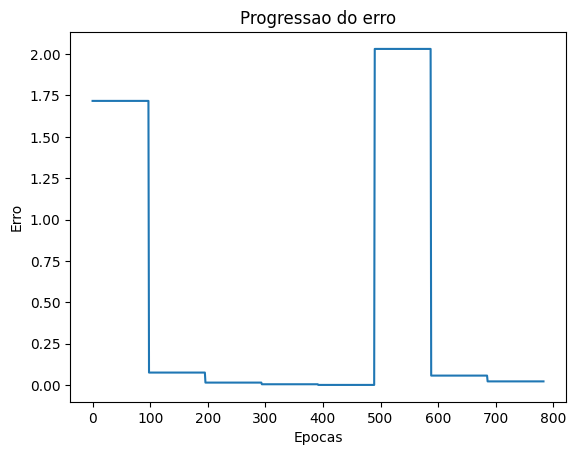

In [35]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressao do erro')
plt.xlabel('Epocas')
plt.ylabel('Erro')

In [36]:
modelo.to_disk("modelo_best")

In [37]:
modelo_carregado = spacy.load("modelo_best")
modelo_carregado

In [38]:
previsoes = []
for texto in base_dados_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [39]:
previsoes

[{'POSITIVO': 0.9999996423721313, 'NEGATIVO': 4.044649983825366e-07},
 {'POSITIVO': 0.9999991655349731, 'NEGATIVO': 8.015891808099695e-07},
 {'POSITIVO': 0.9999994039535522, 'NEGATIVO': 6.011797495375504e-07},
 {'POSITIVO': 0.9999990463256836, 'NEGATIVO': 1.0043179372587474e-06},
 {'POSITIVO': 0.999997615814209, 'NEGATIVO': 2.337814976272057e-06},
 {'POSITIVO': 0.9999995231628418, 'NEGATIVO': 5.33372656263964e-07},
 {'POSITIVO': 0.9999991655349731, 'NEGATIVO': 8.896728331819759e-07},
 {'POSITIVO': 0.9999991655349731, 'NEGATIVO': 8.035408995965554e-07},
 {'POSITIVO': 0.9999997615814209, 'NEGATIVO': 2.3306952812163217e-07},
 {'POSITIVO': 0.9999994039535522, 'NEGATIVO': 6.223761488399759e-07},
 {'POSITIVO': 0.9999995231628418, 'NEGATIVO': 5.255062092146545e-07},
 {'POSITIVO': 0.9999996423721313, 'NEGATIVO': 4.086609806108754e-07},
 {'POSITIVO': 0.9999984502792358, 'NEGATIVO': 1.5888946336417575e-06},
 {'POSITIVO': 0.9999995231628418, 'NEGATIVO': 4.3138174987689126e-07},
 {'POSITIVO': 0.99

In [40]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)
previsoes_final = np.array(previsoes_final)

In [41]:
previsoes_final

array([1, 1, 1, ..., 0, 0, 0])

In [42]:
respostas_reais = base_dados_teste['sentiment'].values
respostas_reais

array([1, 1, 1, ..., 0, 0, 0])

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final)

0.9974

In [44]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2492,    8],
       [   5, 2495]])